In [19]:
from matplotlib import pyplot as plt

import diversity_metrics
import numpy as np
import pandas as pd
import warnings

# Suppress warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import and clean data

In [2]:
# import data
pc_species = pd.read_csv('point-count-species-clean.csv')

# manual cleaning
pc_species[['Date']] = pc_species[['Date']].replace(to_replace = {'11/1/2023':'11/01/2023',
                                                                  '11/11/23': '11/11/2023',
                                                                  '12/2/2023': '12/02/2023'})
pc_species['Date'] = pd.to_datetime(pc_species['Date'])
pc_species['Species'] = pc_species['Species'].str.lower()

valid_pc_data = pd.read_csv('pc-data-with-completeness.csv')
valid_pcs = list(valid_pc_data['PC #'].unique())
pc_species = pc_species[pc_species['PC #'].isin(valid_pcs)]

pc_species

,PC #,Date,Location,Time Bin,Species,# Individuals,Notes,Editorial notes,Jon Problem Checker
0,1,2023-10-06,A1,Morning (7-9am),rock pigeon,3.0,NaN,NaN,-
1,1,2023-10-06,A1,Morning (7-9am),anna's hummingbird,3.0,NaN,NaN,-
2,1,2023-10-06,A1,Morning (7-9am),nuttall's woodpecker,1.0,NaN,NaN,-
3,1,2023-10-06,A1,Morning (7-9am),american crow,3.0,NaN,NaN,-
4,1,2023-10-06,A1,Morning (7-9am),dark-eyed junco,2.0,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...
4825,795,2024-04-27,B5,Evening (3-5pm),dark-eyed junco,4.0,NaN,NaN,-
4826,796,2024-04-27,B6,Evening (3-5pm),american crow,4.0,NaN,NaN,-
4827,796,2024-04-27,B6,Evening (3-5pm),common raven,2.0,NaN,NaN,-
4828,796,2024-04-27,B6,Evening (3-5pm),red-breasted nuthatch,1.0,NaN,NaN,-


In [3]:
pc_dates = pc_species['Date'].unique()
species_seen = sorted(pc_species['Species'].unique())

### Calculate abundance and frequency for all species seen

We are measuring abundance in number of survey days seen and frequency in abundance divided by total number of survey days (51). Multiple point counts were done on each day, but we are aggregating all point counts done on the same day.

In [4]:
species_abundances = [diversity_metrics.abundance_days_seen(pc_species, species) for species in species_seen]
species_frequencies = [diversity_metrics.frequency_days_seen(pc_species, species) for species in species_seen]

In [5]:
abundance_and_frequency = pd.DataFrame()
abundance_and_frequency['Species'] = species_seen
abundance_and_frequency['Abundance'] = species_abundances
abundance_and_frequency['Frequency'] = species_frequencies
abundance_and_frequency

,Species,Abundance,Frequency
0,accipiter_genus,3,0.065217
1,accipitridae_family,2,0.043478
2,allen's hummingbird,1,0.021739
3,american crow,46,1.000000
4,american goldfinch,1,0.021739
...,...,...,...
70,white-throated swift,3,0.065217
71,wild turkey,1,0.021739
72,wilson's warbler,1,0.021739
73,yellow-rumped warbler,39,0.847826


In [6]:
# Frequency -> mean and variance
mean_frequency = np.mean(abundance_and_frequency['Frequency'])
frequency_variance = np.var(abundance_and_frequency['Frequency'])
mean_frequency, frequency_variance

(0.3640579710144928, 0.1324145347616047)

In [7]:
abundance_and_frequency.sort_values("Frequency")

,Species,Abundance,Frequency
27,falco_genus,1,0.021739
55,setophaga_genus,1,0.021739
56,sharp-shinned hawk,1,0.021739
24,corvidae_family,1,0.021739
59,spinus_genus,1,0.021739
...,...,...,...
19,chestnut-backed chickadee,46,1.000000
7,anna's hummingbird,46,1.000000
5,american robin,46,1.000000
3,american crow,46,1.000000


The observed mean frequency across the 7-month survey period was 0.364, and the observed variance across the survey period was 0.132. Compared to the Spring 2023 data (mean 0.306 and variance 0.0926), the data across this survey period had a higher mean and a higher variance.

Across all the valid point counts (as defined in `data-cleaning.ipynb`), six species that were seen in every valid survey day:
- American Crow (*Corvus brachyrhynchos*)
- American Robin (*Turdus migratorius*)
- Anna's Hummingbird (*Calypte anna*)
- Chestnut-backed Chickadee (*Poecile rufescens*)
- Dark-eyed Junco (*Junco hyemalis*)\*
- House Finch (*Haemorhous mexicanus*)

\*All subspecies of the Dark-eyed Junco were consolidated into one species-level taxon.

Note that frequency is being calculated as a measure of days seen divided by *total* valid survey days, and the number of valid survey days (46) is less than the number of total days surveyed (50).

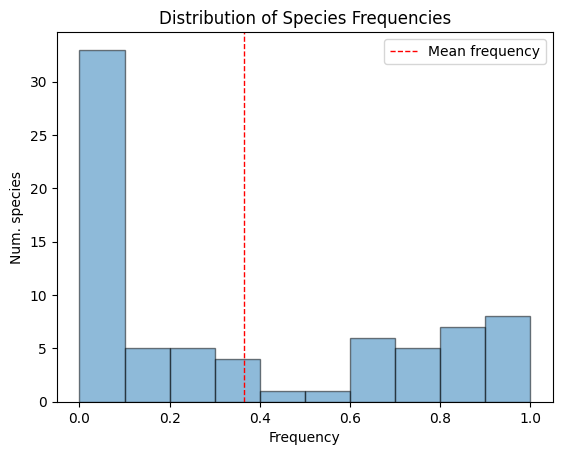

In [16]:
# Plot histogram of species frequencies and average frequency
plt.hist(x = abundance_and_frequency['Frequency'], bins = np.linspace(0, 1, 11), alpha = 0.5, histtype='bar', ec='black')
plt.axvline(np.mean(abundance_and_frequency['Frequency']), color='r', linestyle='dashed', linewidth=1, label = "Mean frequency")
plt.xlabel("Frequency")
plt.ylabel("Num. species")
plt.title("Distribution of Species Frequencies")
plt.legend()

The histogram above shows a strongly right-skewed distribution of species frequencies, with many species seen over the survey period having frequencies 0.1 or less. Therefore, we might have seen a lot of rarer species across the survey period; however, this bin may include taxa that are higher than the spcecies level (e.g. "corvidae_family"). These taxa will likely be filtered out.

In [17]:
abundance_and_frequency.to_csv('species-abundance-and-frequency.csv')

The abundance and frequency data can be seen in `species-abundance-and-frequency.csv`.

### Calculate Simpson and Shannon Diversity for all dates

In [20]:
date_simpson_diversity = [diversity_metrics.simpson_diversity(pc_species, date) for date in pc_dates]
date_shannon_diversity = [diversity_metrics.shannon_diversity(pc_species, date) for date in pc_dates]

In [21]:
simpson_and_shannon = pd.DataFrame()
simpson_and_shannon['Date'] = pc_dates
simpson_and_shannon['Simpson Diversity'] = date_simpson_diversity
simpson_and_shannon['Shannon Diversity'] = date_shannon_diversity
first_date = simpson_and_shannon['Date'][0]
simpson_and_shannon['Days Since First PC'] = pd.Series([(date - first_date).days for date in simpson_and_shannon['Date']])
simpson_and_shannon

,Date,Simpson Diversity,Shannon Diversity,Days Since First PC
0,2023-10-06,0.831172,2.172987,0
1,2023-10-12,0.854499,2.348290,6
2,2023-10-14,0.878946,2.533530,8
3,2023-10-20,0.752022,2.058189,14
4,2023-10-22,0.885835,2.657016,16
5,2023-10-25,0.789655,2.236598,19
6,2023-10-28,0.864841,2.501920,22
7,2023-10-31,0.889235,2.743488,25
8,2023-11-01,0.694013,1.913557,26
9,2023-11-05,0.897261,2.725319,30


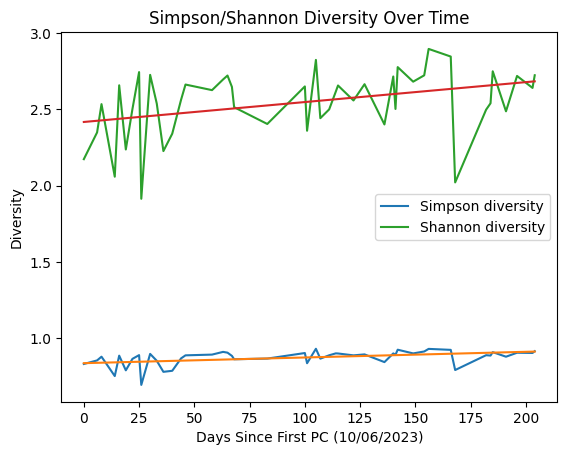

In [22]:
# Plot Simpson and Shannon Diversity, plus best fit lines
plt.plot(simpson_and_shannon['Days Since First PC'], date_simpson_diversity, label = "Simpson diversity")
simpson_m, simpson_b = np.polyfit(x = simpson_and_shannon['Days Since First PC'], y = date_simpson_diversity, deg = 1)
plt.plot(simpson_and_shannon['Days Since First PC'],
         simpson_m * simpson_and_shannon['Days Since First PC'] + simpson_b)

plt.plot(simpson_and_shannon['Days Since First PC'], date_shannon_diversity, label = "Shannon diversity")
shannon_m, shannon_b = np.polyfit(x = simpson_and_shannon['Days Since First PC'], y = date_shannon_diversity, deg = 1)
plt.plot(simpson_and_shannon['Days Since First PC'],
         shannon_m * simpson_and_shannon['Days Since First PC'] + shannon_b)

plt.title("Simpson/Shannon Diversity Over Time")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Diversity")
plt.legend()

Above, I plotted the Simpson/Shannon Diversity over the entire 7-month survey period (October 2023-April 2024), plus their best fit lines. Both Simpson and Shannon diversity had peaks and valleys in similar places, but the peaks and valleys were both more pronounced in Shannon Diversity. The Shannon Diversity also had a much higher variance, but I believe that this difference is due to the differences in how the two measures are calculated.

In [23]:
# Calculate mean and variance for Simpson and Shannon diversity
mean_simpson, var_simpson = np.mean(simpson_and_shannon['Simpson Diversity']), np.var(simpson_and_shannon['Simpson Diversity'])
mean_shannon, var_shannon = np.mean(simpson_and_shannon['Shannon Diversity']), np.var(simpson_and_shannon['Shannon Diversity'])

### Calculate alpha diversity for each survey period

In [24]:
alpha_diversity = pd.DataFrame()
alpha_diversity['Date'] = pc_dates
alpha_diversity['Alpha Diversity'] = [diversity_metrics.alpha_diversity(pc_species, date) for date in pc_dates]
alpha_diversity['Days Since First PC'] = simpson_and_shannon['Days Since First PC']
alpha_diversity

,Date,Alpha Diversity,Days Since First PC
0,2023-10-06,1.203121,0
1,2023-10-12,1.170276,6
2,2023-10-14,1.137727,8
3,2023-10-20,1.329748,14
4,2023-10-22,1.128879,16
5,2023-10-25,1.266376,19
6,2023-10-28,1.156282,22
7,2023-10-31,1.124562,25
8,2023-11-01,1.440896,26
9,2023-11-05,1.114503,30


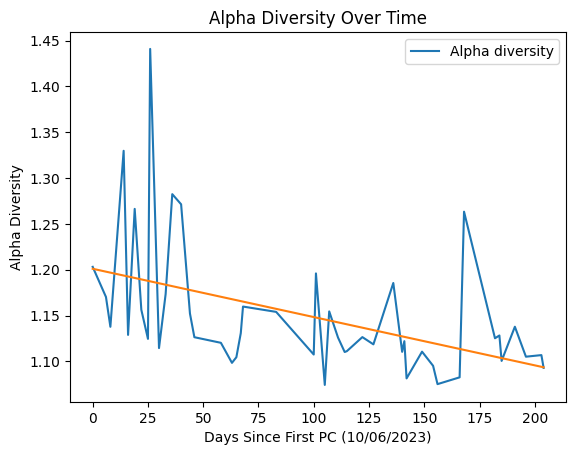

In [25]:
# Plot Alpha Diversity, plus best fit line
plt.plot(alpha_diversity['Days Since First PC'], alpha_diversity['Alpha Diversity'], label = "Alpha diversity")
alpha_m, alpha_b = np.polyfit(x = alpha_diversity['Days Since First PC'], y = alpha_diversity['Alpha Diversity'], deg = 1)
plt.plot(alpha_diversity['Days Since First PC'],
         alpha_m * alpha_diversity['Days Since First PC'] + alpha_b)

plt.title("Alpha Diversity Over Time")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Alpha Diversity")
plt.legend()

The above graph displays the Alpha Diversity plotted over time, starting from the first point count. While the variance seems to be high, there is a clear downward trend across the entire survey period. Notably, this trend differs from the increases in Simpson and Shannon Diversity.

Because Alpha Diveristy is calculated as 1/(Simpson Diversity), these trends make sense numerically. In order to explain qualitatively why this difference makes sense, we must first consider the definition of Simpson Diversity as the probability that two individuals chosen at random are of different species. (I am a little confused about this so I will probably follow up with Sierra and Leena about this.)